In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
from evojax.util import get_params_format_fn

import os
import time
import numpy as np
import pandas as pd
from scipy import io
import matplotlib.pyplot as plt
import argparse

# choose GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_matmul_precision", "highest")

In [2]:
"""DNN / PINN   """

class PINN(nn.Module):
    """PINNs"""
    n_nodes:int
    def setup(self):
        # initialization
        kinit = jax.nn.initializers.he_uniform()
        # feature mapping later
        self.feats = nn.Dense(self.n_nodes * 4, kernel_init = kinit)
        # hidden layers
        self.layers = [nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu]
        # split layers
        self.splitu = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layeru = [nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu,
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitv = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layerv = [nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu,
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitp = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layerp = [nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu,
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]

    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        x, y = inputs[:,0:1], inputs[:,1:2]
        def get_uvp(x, y):
            inputs = jnp.hstack([x, y, x - 1., y - 1.])
            # feature mapping
            hidden = self.feats(inputs)
            hidden = jnp.sin(2*jnp.pi*hidden)
            # share hidden layer
            for i, lyr in enumerate(self.layers):
                hidden = lyr(hidden)
            # split hidden layer
            u = self.splitu(hidden)
            for i, lyr in enumerate(self.layeru):
                u = lyr(u)
            v = self.splitv(hidden)
            for i, lyr in enumerate(self.layerv):
                v = lyr(v)
            p = self.splitp(hidden)
            for i, lyr in enumerate(self.layerp):
                p = lyr(p)
            return (u, v, p)

        u, v, p = get_uvp(x, y)

        # obtain u_x, u_y, v_x, v_y, p_x, p_y
        def get_uvp_xy(get_uvp, x, y):
            u_x, v_x, p_x = jacfwd(get_uvp)(x, y)
            u_y, v_y, p_y = jacfwd(get_uvp, argnums=1)(x, y)
            return u_x, u_y, v_x, v_y, p_x , p_y

        get_uvp_xy_vmap = vmap(get_uvp_xy, in_axes=(None, 0, 0))
        u_x, u_y, v_x, v_y, p_x, p_y = get_uvp_xy_vmap(get_uvp, x, y)
        u_x, u_y, v_x, v_y, p_x, p_y = u_x[:,:,0], u_y[:,:,0], v_x[:,:,0], v_y[:,:,0], p_x[:,:,0] , p_y[:,:,0]

       # obtain u_xx, u_yy, v_xx, v_yy, p_xx, p_yy
        def get_uvp_xxyy(get_uvp, x, y):
            u_xx, v_xx, p_xx = jacfwd(jacfwd(get_uvp))(x, y)
            u_yy, v_yy, p_yy = jacfwd(jacfwd(get_uvp, argnums=1), argnums=1)(x, y)
            return u_xx, u_yy, v_xx, v_yy, p_xx , p_yy

        get_uvp_xxyy_vmap = vmap(get_uvp_xxyy, in_axes=(None, 0, 0))
        u_xx, u_yy, v_xx, v_yy, p_xx, p_yy = get_uvp_xxyy_vmap(get_uvp, x, y)
        u_xx, u_yy, v_xx, v_yy, p_xx, p_yy = u_xx[:,:,0,0], u_yy[:,:,0,0], v_xx[:,:,0,0], v_yy[:,:,0,0], p_xx[:,:,0,0] , p_yy[:,:,0,0]

        # obtain BC indices
        bc  = (x == x_l) | (x == x_u) | (y == y_l) | (y == y_u)
        nbc = (~bc)

        # compute PDE residual : N-S equations
        # continuity = u_x + v_y
        # momentum_1 = u*u_x + v*u_y + p_x - 1.0/Re*(u_xx + u_yy)
        # momentum_2 = u*v_x + v*v_y + p_y - 1.0/Re*(v_xx + v_yy)
        residuals_continuity = u_x + v_y
        residuals_momentum_1 = u*u_x + v*u_y + p_x - 1.0/Re*(u_xx + u_yy)
        residuals_momentum_2 = u*v_x + v*v_y + p_y - 1.0/Re*(v_xx + v_yy)

        mom1 = -1.0/Re*(u_xx + u_yy)
        mom2 = -1.0/Re*(v_xx + v_yy)

        outputs = jnp.hstack([u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, bc, nbc, mom1, mom2])
        return outputs


class DNN(nn.Module):
    """DNNs"""
    n_nodes:int
    def setup(self):
        # initialization
        kinit = jax.nn.initializers.he_uniform()
        # feature mapping later
        self.feats = nn.Dense(self.n_nodes * 4, kernel_init = kinit)
        # hidden layers
        self.layers = [nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu]
        # split layers
        self.splitu = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layeru = [nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu,
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitv = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layerv = [nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu,
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitp = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layerp = [nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn.silu,
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]

    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        x, y = inputs[:,0:1], inputs[:,1:2]
        def get_uvp(x, y):
            inputs = jnp.hstack([x, y, x - 1., y - 1.])
            # feature mapping
            hidden = self.feats(inputs)
            hidden = jnp.sin(2*jnp.pi*hidden)
            # share hidden layer
            for i, lyr in enumerate(self.layers):
                hidden = lyr(hidden)
            # split hidden layer
            u = self.splitu(hidden)
            for i, lyr in enumerate(self.layeru):
                u = lyr(u)
            v = self.splitv(hidden)
            for i, lyr in enumerate(self.layerv):
                v = lyr(v)
            p = self.splitp(hidden)
            for i, lyr in enumerate(self.layerp):
                p = lyr(p)
            return (u, v, p)

        u, v, p = get_uvp(x, y)

       # obtain u_xx, u_yy, v_xx, v_yy, p_xx, p_yy
        def get_uvp_xxyy(get_uvp, x, y):
            u_xx, v_xx, _ = jacfwd(jacfwd(get_uvp))(x, y)
            u_yy, v_yy, _ = jacfwd(jacfwd(get_uvp, argnums=1), argnums=1)(x, y)
            return u_xx, u_yy, v_xx, v_yy

        get_uvp_xxyy_vmap = vmap(get_uvp_xxyy, in_axes=(None, 0, 0))
        u_xx, u_yy, v_xx, v_yy = get_uvp_xxyy_vmap(get_uvp, x, y)
        u_xx, u_yy, v_xx, v_yy = u_xx[:,:,0,0], u_yy[:,:,0,0], v_xx[:,:,0,0], v_yy[:,:,0,0]

        mom1 = -1.0/Re*(u_xx + u_yy)
        mom2 = -1.0/Re*(v_xx + v_yy)

        #shift p_ref
        x_pref, y_pref = jnp.ones_like(x)*x_ref, jnp.ones_like(y)*y_ref
        _, _, pref = get_uvp(x_pref, y_pref)
        pout = p - pref

        outputs = jnp.hstack([u, v, pout, mom1, mom2])
        return outputs

In [3]:
def main(ER, ER_xx, weight_bc, max_lr, exponent, max_iters, seed, gpu):

    global  Re, x_l, x_u, y_l, y_u, x_ref, y_ref, dx, dy

    Re = 3200
    
    sim = pd.read_csv('LDC_RE3200_100x100_subsample200x200.csv')
    data_X, data_Y = sim[['x', 'y']].values, sim[['u', 'v', 'p']].values
    
    # dx & dy
    dx = dy = 1 / (101-1)

    # exclude corner points
    x_l, x_u, y_l, y_u = np.min(data_X[:,0]), np.max(data_X[:,0]), np.min(data_X[:,1]), np.max(data_X[:,1])
    corners = (sim.x == x_l) & (sim.y == y_u) | (sim.x == x_u) & (sim.y == y_u) | (sim.x == x_l) & (sim.y == y_l) | (sim.x == x_u) & (sim.y == y_l)
    data_X, data_Y = data_X[~corners], data_Y[~corners]

    # pressure ref
    x_ref, y_ref = np.unique(sim.x), np.unique(sim.y)
    x_ref, y_ref = np.take(x_ref, x_ref.size //2), np.take(y_ref, y_ref.size //2)

    # split into BC data
    bc = (data_X[:,0] == x_l) | (data_X[:,0] == x_u) | (data_X[:,1] == y_l) | (data_X[:,1] == y_u)
    data_X_BC, data_Y_BC = data_X[bc], data_Y[bc]

    # convert to jnp
    data_X, data_Y, data_X_BC, data_Y_BC = jnp.array(data_X), jnp.array(data_Y), jnp.array(data_X_BC), jnp.array(data_Y_BC)

    
    # choose seed
    seed = seed
    key, rng = random.split(random.PRNGKey(seed))

    # dummy input
    a = random.normal(key, [1,2])

    # initialization call
    n_nodes = 32
    model, model_0 = PINN(n_nodes), DNN(n_nodes)
    params = model.init(key, a)
    num_params, format_params_fn = get_params_format_fn(params)

    # flatten initial params
    params = jax.flatten_util.ravel_pytree(params)[0]

    # update u_0
    params_0 = params

    # minibatch (set #sample)
    BS_ALL = 400
    BS_BC = 50

    n_all, n_bc = len(data_X), len(data_X_BC)

    @jit
    def minibatch(key):
        key1, key2 = key
        batch_all = random.choice(key1, n_all, (BS_ALL - BS_BC,))
        batch_bc = random.choice(key2, n_bc, (BS_BC,))
        batch_X = jnp.vstack([data_X[batch_all], data_X_BC[batch_bc]])
        batch_Y = jnp.vstack([data_Y[batch_all], data_Y_BC[batch_bc]])
        return (batch_X, batch_Y)

    # loss function
    def eval_loss(params, params_0, inputs, labels):
        pred = model.apply(format_params_fn(params), inputs)
        u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, bc, nbc, m_1, m_2 = jnp.split(pred, 10, axis=1)
        gt_u, gt_v, gt_p = jnp.split(labels, 3, axis=1)
        # PDE loss unadjusted
        pde_uvp_uadj  = jnp.square(residuals_continuity) + jnp.square(residuals_momentum_1) + jnp.square(residuals_momentum_2)
        pde_loss_uadj = jnp.sum(pde_uvp_uadj *nbc) / nbc.sum()
        # stable evolution
        pred0 = model_0.apply(format_params_fn(params_0), inputs)
        u_0, v_0, p_0, m0_1, m0_2 = jnp.split(pred0, 5, axis=1)
        # PDE
        if (ER > 0):
            residuals_continuity = residuals_continuity + (p - p_0) / ER # ER @PDE
            residuals_momentum_1 = residuals_momentum_1 + (u - u_0) / ER + (m_1 - m0_1) / ER_xx # ER @PDE
            residuals_momentum_2 = residuals_momentum_2 + (v - v_0) / ER + (m_2 - m0_2) / ER_xx # ER @PDE
        pde_uvp  = jnp.square(residuals_continuity) + jnp.square(residuals_momentum_1) + jnp.square(residuals_momentum_2)
        pde_loss = jnp.sum(pde_uvp *nbc) / nbc.sum()
        # BC
        bc_loss = jnp.sum(jnp.square(u - gt_u) *bc) / bc.sum() + jnp.sum(jnp.square(v - gt_v) *bc) / bc.sum()
        # mse
        uv, gt_uv = jnp.hstack([u, v]), jnp.hstack([gt_u, gt_v])
        mse = jnp.mean(jnp.square(uv - gt_uv))
        rl2 = jnp.linalg.norm(uv - gt_uv) / jnp.linalg.norm(gt_uv)
        loss = pde_loss + weight_bc* bc_loss
        return loss, (mse, rl2, pde_loss, pde_loss_uadj)

    loss_grad = jax.jit(jax.value_and_grad(eval_loss, has_aux=True))

    @jit
    def eval_ghia(params, x_ref_ghia, y_ref_ghia, v_ref_ghia, u_ref_ghia):
        # prediction
        u_pinn_ghia = model_0.apply(format_params_fn(params), y_ref_ghia)[:,0]
        v_pinn_ghia = model_0.apply(format_params_fn(params), x_ref_ghia)[:,1]
        ghia_uv, pinn_uv = jnp.vstack([u_ref_ghia, v_ref_ghia]).T, jnp.vstack([u_pinn_ghia, v_pinn_ghia]).T
        ghia_mse = jnp.mean(jnp.square(ghia_uv - pinn_uv))
        ghia_rl2 = jnp.linalg.norm(ghia_uv - pinn_uv) / jnp.linalg.norm(ghia_uv)
        return ghia_mse, ghia_rl2, pinn_uv

    # weights update
    @jit
    def update(params, params_0, opt_state, key):
        batch_X, batch_Y = minibatch(key)
        (loss, (mse, rl2, pde_loss, pde_loss_uadj)), grad = loss_grad(params, params_0, batch_X, batch_Y)
        updates, opt_state = optimizer.update(grad, opt_state)
        params_0 = params # update u_0
        params = optax.apply_updates(params, updates)
        return params, params_0, opt_state, loss, mse, rl2, pde_loss, pde_loss_uadj

    # optimizer
    max_iters = max_iters
    max_lr = max_lr
    lr_scheduler = optax.warmup_cosine_decay_schedule(init_value=max_lr, peak_value=max_lr, warmup_steps=0,
                                                      decay_steps=max_iters, end_value=1e-10 ,exponent=exponent)
    optimizer = optax.adam(learning_rate=lr_scheduler) # Choose the method
    opt_state = optimizer.init(params)

    """Training"""

    # training iteration
    runtime = 0
    train_iters = 0

    # store = []
    # store_ghia = []
    # store_loss = []
    store_nnws = []
    store_nnws.append([0, format_params_fn(params)])
    
    # CFD @ Ghia cut lines
    u_ghia, v_ghia = pd.read_csv('LDC_512x512_y_u.dat',sep='\\s+'), pd.read_csv('LDC_512x512_x_v.dat',sep='\\s+')
    x_ghia, y_ghia = v_ghia.x.values, u_ghia.y.values
    x_ref_ghia, y_ref_ghia = jnp.vstack([x_ghia, jnp.ones_like(x_ghia) *0.5]).T, jnp.vstack([jnp.ones_like(y_ghia) *0.5, y_ghia]).T
    v_ref_ghia, u_ref_ghia = v_ghia.v.values, u_ghia.u.values  

    while (train_iters <= max_iters) and (runtime < 300):
        # mini-batch update
        start = time.time()
        key1, key2, rng = random.split(rng, 3) # update random generator
        params, params_0, opt_state, loss, mse, rl2, pde_loss, pde_loss_uadj = update(params, params_0, opt_state, (key1, key2))
        end = time.time()
        runtime += (end-start)
        # store_loss.append([train_iters, loss, mse, rl2, pde_loss, pde_loss_uadj])
        # append weights
        if (train_iters % 500 == 0):
            #print ('iter. = %05d,  time = %03ds,  loss = %.2e  |  mse = %.2e,  rl2 = %.2e'%(train_iters, runtime, loss, mse, rl2))
            #store.append([train_iters, runtime, loss, mse, rl2])
            ghia_mse, ghia_rl2, pinn_uv = eval_ghia(params, x_ref_ghia, y_ref_ghia, v_ref_ghia, u_ref_ghia)
            print ('iter. = %05d,  time = %03ds,  loss = %.2e  |  mse = %.2e,  rl2 = %.2e  |  Ghia mse = %.2e,  Ghia rl2 = %.2e'%(train_iters, runtime, 
                                                                                                                                  loss, mse, rl2,
                                                                                                                                  ghia_mse, ghia_rl2))
            # store.append([train_iters, runtime, loss, mse, rl2, ghia_mse, ghia_rl2])
            # store_ghia.append(pinn_uv)
            store_nnws.append([runtime, format_params_fn(params)])
        train_iters += 1

    # store, store_ghia, store_loss = jnp.array(store), np.array(store_ghia), np.array(store_loss)

    """PINN solution"""
    inputs, labels = data_X, data_Y
    prediction = model_0.apply(format_params_fn(params), inputs)
    u, v, _, _, _ = jnp.split(prediction, 5, axis=-1)
    gt_u, gt_v, gt_p = jnp.split(labels, 3, axis=-1)
    # prediction errors
    uv, gt_uv = jnp.hstack([u, v]), jnp.hstack([gt_u, gt_v])
    mse = jnp.mean(jnp.square(uv - gt_uv))
    rl2 = jnp.linalg.norm(uv - gt_uv) / jnp.linalg.norm(gt_uv)
    print ('[In-house] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2))

    """prediction @ Ghia"""
    ghia_mse, ghia_rl2, _ = eval_ghia(params, x_ref_ghia, y_ref_ghia, v_ref_ghia, u_ref_ghia)
    print ('[Ghia]     :  MSE = %.2e  RL2 = %.2e'%(ghia_mse, ghia_rl2))

    # """prediction @ JAX-PI"""
    # from scipy import io
    # mat_data = io.loadmat('ldc_Re3200.mat')
    # xx, yy = mat_data['x'].reshape(-1,1), mat_data['y'].reshape(-1,1)
    # x_256, y_256 = jnp.meshgrid(xx[:,0], yy[:,0], indexing='ij')
    # u_256, v_256 = mat_data['u'], mat_data['v']
    # xy_256 = jnp.hstack([x_256.reshape(-1,1), y_256.reshape(-1,1)])
    # uv_256 = jnp.hstack([u_256.reshape(-1,1), v_256.reshape(-1,1)])
    # # prediction errors
    # uv_pinn = model_0.apply(format_params_fn(params), xy_256)[:,:2]
    # jaxpi_mse = jnp.mean(jnp.square(uv_256 - uv_pinn))
    # jaxpi_rl2 = jnp.linalg.norm(uv_256 - uv_pinn) / jnp.linalg.norm(uv_256)
    # print ('[JAX-PI]   :  MSE = %.2e  RL2 = %.2e'%(jaxpi_mse, jaxpi_rl2))
    
    return format_params_fn(params), store_nnws

In [4]:
# run main (ER)
params, store_nnws = main(ER=0.06, ER_xx=1, weight_bc=15,
                     max_lr=5e-4, exponent=0.8, max_iters=50000, seed=50, gpu=0)

2025-10-08 23:09:55.531744: E external/xla/xla/service/hlo_lexer.cc:438] Failed to parse int literal: 894515288310727292233


iter. = 00000,  time = 007s,  loss = 2.67e+01  |  mse = 1.32e-01,  rl2 = 1.55e+00  |  Ghia mse = 3.60e-01,  Ghia rl2 = 1.50e+00
iter. = 00500,  time = 008s,  loss = 2.08e-01  |  mse = 3.06e-02,  rl2 = 6.87e-01  |  Ghia mse = 9.88e-02,  Ghia rl2 = 7.85e-01
iter. = 01000,  time = 009s,  loss = 1.16e-01  |  mse = 3.67e-02,  rl2 = 8.42e-01  |  Ghia mse = 1.09e-01,  Ghia rl2 = 8.26e-01
iter. = 01500,  time = 010s,  loss = 7.56e-02  |  mse = 3.13e-02,  rl2 = 7.68e-01  |  Ghia mse = 1.13e-01,  Ghia rl2 = 8.40e-01
iter. = 02000,  time = 010s,  loss = 1.61e-02  |  mse = 3.24e-02,  rl2 = 7.85e-01  |  Ghia mse = 1.14e-01,  Ghia rl2 = 8.43e-01
iter. = 02500,  time = 011s,  loss = 4.00e-02  |  mse = 3.27e-02,  rl2 = 7.02e-01  |  Ghia mse = 1.13e-01,  Ghia rl2 = 8.39e-01
iter. = 03000,  time = 012s,  loss = 6.85e-02  |  mse = 3.33e-02,  rl2 = 7.17e-01  |  Ghia mse = 1.14e-01,  Ghia rl2 = 8.41e-01
iter. = 03500,  time = 013s,  loss = 1.36e-01  |  mse = 3.13e-02,  rl2 = 7.54e-01  |  Ghia mse = 1.15e-0

In [5]:
# 5 runs
params_5, store_nnws_5 = {}, {}
for seed in [90, 10, 70, 30, 50]:
    # run main (ER)
    params, store_nnws = main(ER=0.06, ER_xx=1, weight_bc=15,
                         max_lr=5e-4, exponent=0.8, max_iters=50000, seed=seed, gpu=0)    
    params_5[seed] = params
    store_nnws_5[seed] = store_nnws

iter. = 00000,  time = 006s,  loss = 5.41e+01  |  mse = 2.19e-01,  rl2 = 1.94e+00  |  Ghia mse = 2.21e-01,  Ghia rl2 = 1.17e+00
iter. = 00500,  time = 007s,  loss = 1.02e-01  |  mse = 3.33e-02,  rl2 = 8.07e-01  |  Ghia mse = 1.09e-01,  Ghia rl2 = 8.25e-01
iter. = 01000,  time = 007s,  loss = 4.71e-02  |  mse = 3.19e-02,  rl2 = 7.29e-01  |  Ghia mse = 1.10e-01,  Ghia rl2 = 8.28e-01
iter. = 01500,  time = 008s,  loss = 2.61e-02  |  mse = 3.26e-02,  rl2 = 7.59e-01  |  Ghia mse = 1.13e-01,  Ghia rl2 = 8.38e-01
iter. = 02000,  time = 009s,  loss = 1.89e-02  |  mse = 3.34e-02,  rl2 = 7.73e-01  |  Ghia mse = 1.14e-01,  Ghia rl2 = 8.44e-01
iter. = 02500,  time = 010s,  loss = 7.52e-02  |  mse = 3.24e-02,  rl2 = 7.92e-01  |  Ghia mse = 1.15e-01,  Ghia rl2 = 8.46e-01
iter. = 03000,  time = 011s,  loss = 1.49e-01  |  mse = 3.58e-02,  rl2 = 7.47e-01  |  Ghia mse = 1.14e-01,  Ghia rl2 = 8.44e-01
iter. = 03500,  time = 011s,  loss = 3.32e-02  |  mse = 3.44e-02,  rl2 = 7.28e-01  |  Ghia mse = 1.11e-0

In [6]:
# 5 runs (ref)
ref_params_5, ref_store_nnws_5 = {}, {}
for seed in [90, 10, 70, 30, 50]:
    # run main (NER)
    params, store_nnws = main(ER=0, ER_xx=1, weight_bc=15,
                              max_lr=5e-4, exponent=0.8, max_iters=50000, seed=seed, gpu=0)    
    ref_params_5[seed] = params
    ref_store_nnws_5[seed] = store_nnws

iter. = 00000,  time = 007s,  loss = 5.30e+01  |  mse = 2.19e-01,  rl2 = 1.94e+00  |  Ghia mse = 2.21e-01,  Ghia rl2 = 1.17e+00
iter. = 00500,  time = 008s,  loss = 5.48e-02  |  mse = 3.30e-02,  rl2 = 8.02e-01  |  Ghia mse = 1.09e-01,  Ghia rl2 = 8.24e-01
iter. = 01000,  time = 008s,  loss = 3.25e-02  |  mse = 3.30e-02,  rl2 = 7.41e-01  |  Ghia mse = 1.07e-01,  Ghia rl2 = 8.15e-01
iter. = 01500,  time = 009s,  loss = 3.15e-02  |  mse = 3.48e-02,  rl2 = 7.84e-01  |  Ghia mse = 1.09e-01,  Ghia rl2 = 8.23e-01
iter. = 02000,  time = 010s,  loss = 1.32e-02  |  mse = 3.57e-02,  rl2 = 7.99e-01  |  Ghia mse = 1.11e-01,  Ghia rl2 = 8.32e-01
iter. = 02500,  time = 011s,  loss = 3.38e-02  |  mse = 3.44e-02,  rl2 = 8.17e-01  |  Ghia mse = 1.14e-01,  Ghia rl2 = 8.42e-01
iter. = 03000,  time = 011s,  loss = 1.14e-01  |  mse = 3.82e-02,  rl2 = 7.72e-01  |  Ghia mse = 1.15e-01,  Ghia rl2 = 8.46e-01
iter. = 03500,  time = 012s,  loss = 2.35e-02  |  mse = 3.78e-02,  rl2 = 7.64e-01  |  Ghia mse = 1.15e-0

    iter. = 50000,  time = 088s,  loss = 2.98e-04  |  mse = 1.25e-05,  rl2 = 1.58e-02  |  Ghia mse = 6.62e-05,  Ghia rl2 = 2.03e-02
    [In-house] :  MSE = 1.49e-05  RL2 = 1.74e-02
    [Ghia]     :  MSE = 6.62e-05  RL2 = 2.03e-02

In [7]:
# data
Re = 3200
sim = pd.read_csv('LDC_RE3200_100x100_subsample200x200.csv')
data_X, data_Y = sim[['x', 'y']].values, sim[['u', 'v', 'p']].values
# exclude BC data
x_l, x_u, y_l, y_u = np.min(data_X[:,0]), np.max(data_X[:,0]), np.min(data_X[:,1]), np.max(data_X[:,1])
bcs = (data_X[:,0] == x_l) | (data_X[:,0] == x_u) | (data_X[:,1] == y_l) | (data_X[:,1] == y_u)
corners = (data_X[:,0] == x_l) & (data_X[:,1] == y_u) | (data_X[:,0] == x_u) & (data_X[:,1] == y_u) | (data_X[:,0] == x_l) & (data_X[:,1] == y_l) | (data_X[:,0] == x_u) & (data_X[:,1] == y_l)
#data_X, data_Y = data_X[~bcs], data_Y[~bcs]
inputs, labels = jnp.array(data_X), jnp.array(data_Y)

# model
model = PINN(32)

[In-House] :  MSE = 1.48e-05  RL2 = 1.73e-02


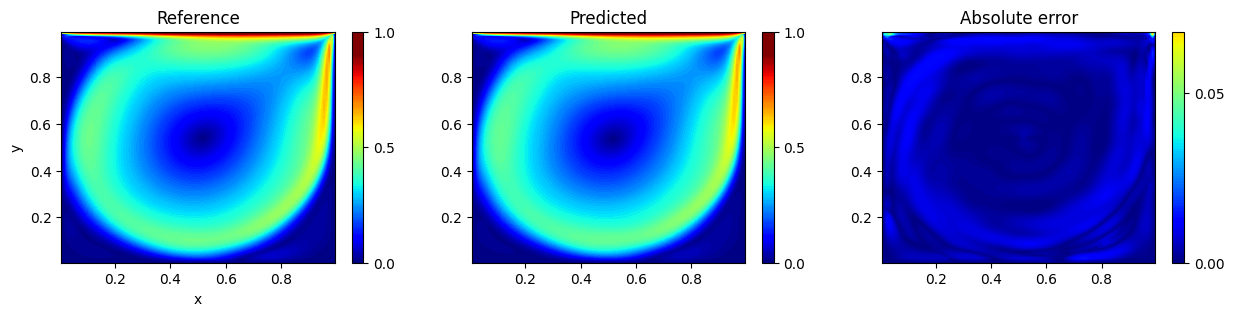

In [8]:
# PINN (final)
params = params_5[50]
pred = model.apply(params, inputs)
u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, bc, nbc, m_1, m_2 = jnp.split(pred, 10, axis=1)
# set corner value
gt_u, gt_v, gt_p = jnp.split(labels, 3, axis=-1)
#u, v = u.at[corners].set(gt_u[corners]), v.at[corners].set(gt_v[corners])
u, v = u.at[bcs].set(gt_u[bcs]), v.at[bcs].set(gt_v[bcs])

# prediction errors
uv, gt_uv = jnp.hstack([u, v]), jnp.hstack([gt_u, gt_v])
mse = jnp.mean(jnp.square(uv - gt_uv))
rl2 = jnp.linalg.norm(uv - gt_uv) / jnp.linalg.norm(gt_uv)
print ('[In-House] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2))

# plot predicted velocity
uv, gt_uv = jnp.sqrt(u**2 + v**2), jnp.sqrt(gt_u**2 + gt_v**2)

# plot inner domain
fig = plt.figure(figsize=(15, 3))
# low fi
con_lv = 101
n = 102
ext = [x_l, x_u, y_l, y_u]
# PINN
ax1 = fig.add_subplot(1,3,1)
clv = plt.contourf(gt_uv.reshape(n, n), con_lv, origin='lower', cmap='jet', extent=ext, vmin=0, vmax=0.9);
plt.colorbar(ticks=[0, 0.5, 1]) ;plt.title('Reference'); plt.xlabel('x'); plt.ylabel('y');
ax1 = fig.add_subplot(1,3,2)
plt.contourf(uv.reshape(n, n), con_lv, origin='lower', cmap='jet', extent=ext, vmin=0, vmax=0.9); plt.colorbar(ticks=[0, 0.5, 1]); plt.title('Predicted'); 
ax1 = fig.add_subplot(1,3,3)
plt.contourf(abs(uv - gt_uv).reshape(n, n), con_lv, origin='lower', cmap='jet', extent=ext, vmin=0, vmax=0.1); plt.colorbar(ticks=[0, 0.05, 0.1]); plt.title('Absolute error');

    [In-House] :  MSE = 1.48e-05  RL2 = 1.73e-02

In [9]:
# average of 5
rl2s = []
for seed in [90, 10, 70, 30, 50]:
    params = params_5[seed]
    pred = model.apply(params, inputs)
    u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, bc, nbc, m_1, m_2 = jnp.split(pred, 10, axis=1)
    # set corner value
    gt_u, gt_v, gt_p = jnp.split(labels, 3, axis=-1)
    #u, v = u.at[corners].set(gt_u[corners]), v.at[corners].set(gt_v[corners])
    u, v = u.at[bcs].set(gt_u[bcs]), v.at[bcs].set(gt_v[bcs])
    # prediction errors
    uv, gt_uv = jnp.hstack([u, v]), jnp.hstack([gt_u, gt_v])
    mse = jnp.mean(jnp.square(uv - gt_uv))
    rl2 = jnp.linalg.norm(uv - gt_uv) / jnp.linalg.norm(gt_uv)
    print ('[In-House] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2))
    rl2s.append(rl2)
rl2s = np.array(rl2s)
print ('[In-House] :  RL2 best = %.2e  ave = %.2e'%(rl2s.min(), rl2s.mean()))

[In-House] :  MSE = 3.17e-05  RL2 = 2.53e-02
[In-House] :  MSE = 1.89e-04  RL2 = 6.18e-02
[In-House] :  MSE = 3.06e-05  RL2 = 2.49e-02
[In-House] :  MSE = 1.81e-04  RL2 = 6.05e-02
[In-House] :  MSE = 1.48e-05  RL2 = 1.73e-02
[In-House] :  RL2 best = 1.73e-02  ave = 3.79e-02


In [10]:
# convergence
p_time2sol_5 = {}
for seed in [90, 10, 70, 30, 50]:
    store_nnws = store_nnws_5[seed]
    p_time2sol = []
    for i in range(0, len(store_nnws), 5):
        runtime, params = store_nnws[i]
        pred = model.apply(params, inputs)
        u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, bc, nbc, m_1, m_2 = jnp.split(pred, 10, axis=1)
        # set corner value
        gt_u, gt_v, gt_p = jnp.split(labels, 3, axis=-1)
        u, v = u.at[bcs].set(gt_u[bcs]), v.at[bcs].set(gt_v[bcs])
        # prediction errors
        uv, gt_uv = jnp.hstack([u, v]), jnp.hstack([gt_u, gt_v])
        mse = jnp.mean(jnp.square(uv - gt_uv))
        rl2 = jnp.linalg.norm(uv - gt_uv) / jnp.linalg.norm(gt_uv)
        #print ('[time = %03ds] :  RL2 = %.2e'%(runtime, rl2))    
        p_time2sol.append([runtime, rl2])
    print ('[time = %03ds] :  RL2 = %.2e'%(runtime, rl2))    
    p_time2sol = np.array(p_time2sol)
    p_time2sol_5[seed] = p_time2sol
#plt.plot(p_time2sol[:,0], p_time2sol[:,1], c='lightgreen', markeredgecolor='green', marker='o', markersize=5, linestyle='-.');
#plt.xlabel('Training time'); plt.ylabel('Relative error'); plt.yscale('log');

[time = 084s] :  RL2 = 2.53e-02
[time = 085s] :  RL2 = 6.17e-02
[time = 085s] :  RL2 = 2.51e-02
[time = 085s] :  RL2 = 6.06e-02
[time = 085s] :  RL2 = 1.73e-02


In [11]:
# convergence (ref)
ref_p_time2sol_5 = {}
for seed in [90, 10, 70, 30, 50]:
    store_nnws = ref_store_nnws_5[seed]
    p_time2sol = []
    for i in range(0, len(store_nnws), 5):
        runtime, params = store_nnws[i]
        pred = model.apply(params, inputs)
        u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, bc, nbc, m_1, m_2 = jnp.split(pred, 10, axis=1)
        # set corner value
        gt_u, gt_v, gt_p = jnp.split(labels, 3, axis=-1)
        u, v = u.at[bcs].set(gt_u[bcs]), v.at[bcs].set(gt_v[bcs])
        # prediction errors
        uv, gt_uv = jnp.hstack([u, v]), jnp.hstack([gt_u, gt_v])
        mse = jnp.mean(jnp.square(uv - gt_uv))
        rl2 = jnp.linalg.norm(uv - gt_uv) / jnp.linalg.norm(gt_uv)
        #print ('[time = %03ds] :  RL2 = %.2e'%(runtime, rl2))    
        p_time2sol.append([runtime, rl2])
    print ('[time = %03ds] :  RL2 = %.2e'%(runtime, rl2))    
    p_time2sol = np.array(p_time2sol)
    ref_p_time2sol_5[seed] = p_time2sol

[time = 082s] :  RL2 = 9.25e-01
[time = 081s] :  RL2 = 9.19e-01
[time = 081s] :  RL2 = 9.17e-01
[time = 082s] :  RL2 = 9.19e-01
[time = 081s] :  RL2 = 9.06e-01


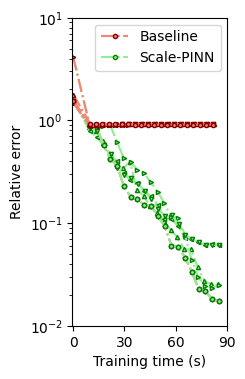

In [12]:
fig = plt.figure(figsize=(2, 4))
makers = ['^', '<', '>', 'v', 'o']
for i, seed in enumerate([90, 10, 70, 30, 50]):
    p_time2sol = p_time2sol_5[seed]
    plt.plot(p_time2sol[:,0], p_time2sol[:,1], c='lightgreen', markeredgecolor='green', marker=makers[i], markersize=3, linestyle='-.');
plt.plot(p_time2sol[:,0], p_time2sol[:,1], c='salmon', markeredgecolor='maroon', marker=makers[i], markersize=3, linestyle='-.', label='Baseline');
plt.plot(p_time2sol[:,0], p_time2sol[:,1], c='lightgreen', markeredgecolor='green', marker=makers[i], markersize=3, linestyle='-.', label='Scale-PINN');
for i, seed in enumerate([90, 10, 70, 30, 50]):
    p_time2sol = ref_p_time2sol_5[seed]
    plt.plot(p_time2sol[:,0], p_time2sol[:,1], c='salmon', markeredgecolor='maroon', marker=makers[i], markersize=3, linestyle='-.');
plt.xlabel('Training time (s)'); plt.ylabel('Relative error'); plt.yscale('log'); plt.ylim(1e-2, 10); plt.xlim(-0.5, 90.5);
plt.xticks([0, 30, 60, 90]); plt.legend();

[In-House] :  MSE = 1.48e-05  RL2 = 1.73e-02


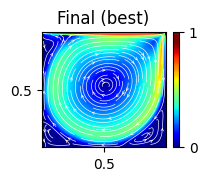

In [13]:
# PINN (final)
params = params_5[50]
pred = model.apply(params, inputs)
u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, bc, nbc, m_1, m_2 = jnp.split(pred, 10, axis=1)
# set corner value
gt_u, gt_v, gt_p = jnp.split(labels, 3, axis=-1)
#u, v = u.at[corners].set(gt_u[corners]), v.at[corners].set(gt_v[corners])
u, v = u.at[bcs].set(gt_u[bcs]), v.at[bcs].set(gt_v[bcs])

# prediction errors
uv, gt_uv = jnp.hstack([u, v]), jnp.hstack([gt_u, gt_v])
mse = jnp.mean(jnp.square(uv - gt_uv))
rl2 = jnp.linalg.norm(uv - gt_uv) / jnp.linalg.norm(gt_uv)
print ('[In-House] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2))

# plot predicted velocity
uv, gt_uv = jnp.sqrt(u**2 + v**2), jnp.sqrt(gt_u**2 + gt_v**2)

# plot inner domain
fig = plt.figure(figsize=(2, 1.5))
# low fi
con_lv = 101
n = 102
ext = [x_l, x_u, y_l, y_u]
test_x, test_y = np.linspace(0,1,n),np.linspace(0,1,n)
# PINN
plt.contourf(uv.reshape(n, n), con_lv, origin='lower', cmap='jet', extent=ext, vmin=0, vmax=0.9);
plt.colorbar(ticks=[0, 1]); plt.title('Final (best)'); 
plt.streamplot(test_x, test_y, np.array(u.reshape(n, n)), np.array(v.reshape(n, n)),
               density=1.1, linewidth=.45, arrowsize=.45, minlength=.1, arrowstyle='->', color='white');
plt.xticks([0.5], ['0.5']); plt.yticks([0.5], ['0.5']); plt.xlim(0.0, 0.999); plt.ylim(0.001, 1.0); 

[In-House] :  MSE = 4.06e-02  RL2 = 9.06e-01


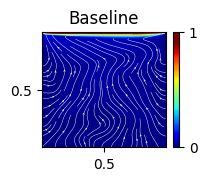

In [14]:
# PINN (ref)
params = ref_params_5[50]
pred = model.apply(params, inputs)
u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, bc, nbc, m_1, m_2 = jnp.split(pred, 10, axis=1)
# set corner value
gt_u, gt_v, gt_p = jnp.split(labels, 3, axis=-1)
#u, v = u.at[corners].set(gt_u[corners]), v.at[corners].set(gt_v[corners])
u, v = u.at[bcs].set(gt_u[bcs]), v.at[bcs].set(gt_v[bcs])

# prediction errors
uv, gt_uv = jnp.hstack([u, v]), jnp.hstack([gt_u, gt_v])
mse = jnp.mean(jnp.square(uv - gt_uv))
rl2 = jnp.linalg.norm(uv - gt_uv) / jnp.linalg.norm(gt_uv)
print ('[In-House] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2))

# plot predicted velocity
uv, gt_uv = jnp.sqrt(u**2 + v**2), jnp.sqrt(gt_u**2 + gt_v**2)

# plot inner domain
fig = plt.figure(figsize=(2, 1.5))
# low fi
con_lv = 101
n = 102
ext = [x_l, x_u, y_l, y_u]
test_x, test_y = np.linspace(0,1,n),np.linspace(0,1,n)
# PINN
plt.contourf(uv.reshape(n, n), con_lv, origin='lower', cmap='jet', extent=ext, vmin=0, vmax=0.9);
plt.colorbar(ticks=[0, 1]); plt.title('Baseline'); 
plt.streamplot(test_x, test_y, np.array(u.reshape(n, n)), np.array(v.reshape(n, n)),
               density=0.9, linewidth=.3, arrowsize=.3, minlength=.1, arrowstyle='->', color='white');
plt.xticks([0.5], ['0.5']); plt.yticks([0.5], ['0.5']); plt.xlim(0.0, 0.999); plt.ylim(0.001, 1.0); 

[In-House] :  MSE = 1.30e-01  RL2 = 1.62e+00


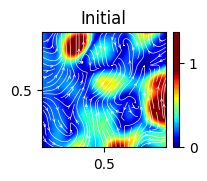

In [15]:
# PINN (initial)
store_nnws = store_nnws_5[50]
runtime, params = store_nnws[0]
pred = model.apply(params, inputs)
u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, bc, nbc, m_1, m_2 = jnp.split(pred, 10, axis=1)
# set corner value
gt_u, gt_v, gt_p = jnp.split(labels, 3, axis=-1)
#u, v = u.at[corners].set(gt_u[corners]), v.at[corners].set(gt_v[corners])
#u, v = u.at[bcs].set(gt_u[bcs]), v.at[bcs].set(gt_v[bcs])

# prediction errors
uv, gt_uv = jnp.hstack([u, v]), jnp.hstack([gt_u, gt_v])
mse = jnp.mean(jnp.square(uv - gt_uv))
rl2 = jnp.linalg.norm(uv - gt_uv) / jnp.linalg.norm(gt_uv)
print ('[In-House] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2))

# plot predicted velocity
uv, gt_uv = jnp.sqrt(u**2 + v**2), jnp.sqrt(gt_u**2 + gt_v**2)

# plot inner domain
fig = plt.figure(figsize=(2, 1.5))
# low fi
con_lv = 101
n = 102
ext = [x_l, x_u, y_l, y_u]
test_x, test_y = np.linspace(0,1,n),np.linspace(0,1,n)
# PINN
plt.contourf(uv.reshape(n, n), con_lv, origin='lower', cmap='jet', extent=ext, vmin=0, vmax=0.9);
plt.colorbar(ticks=[0, 1]); plt.title('Initial'); 
plt.streamplot(test_x, test_y, np.array(u.reshape(n, n)), np.array(v.reshape(n, n)),
               density=1.05, linewidth=.45, arrowsize=.45, minlength=.1, arrowstyle='->', color='white');
plt.xticks([0.5], ['0.5']); plt.yticks([0.5], ['0.5']); plt.xlim(0.0, 0.999); plt.ylim(0.001, 1.0); 